In [1]:
suppressPackageStartupMessages({
  library(dplyr)
  library(cowplot)
  library(magrittr)
  library(dataorganizer)
  library(pagoda2)
  library(ggrepel)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
markers_use <- load_markers_brain(filter_markers=FALSE)
all_ct <- unique(markers_use$marker_of)
markers_use <- lapply(all_ct, \(ct) markers_use[markers_use$marker_of==ct,'gene'])
names(markers_use) <- all_ct

names(markers_use)[which(names(markers_use)=='OD Mature')] <- "Mature oligodendrocyte"
names(markers_use)[which(names(markers_use)=='OD Immature')] <- "Immature oligodendrocyte"

In [3]:
markers_use

$Endothelial
[1] "Slco1a4" "Fn1"    

$Microglia
[1] "Selplg"  "Slc15a3"

$Mural
[1] "Myh11" "Lmod1" "Ace2" 

$`Immature oligodendrocyte`
[1] "Pdgfra"

$`Mature oligodendrocyte`
[1] "Ermn"   "Gjc3"   "Lpar1"  "Opalin" "Ndrg1"  "Etv1"   "Ttyh2"  "Plin3" 

$Excitatory
[1] "Slc17a6" "Bdnf"    "Cbln1"   "Fezf1"   "Ebf3"   

$Inhibitory
 [1] "Gad1"    "Gda"     "Cpne5"   "Baiap2"  "Rgs2"    "Isl1"    "Htr2c"  
 [8] "Ano3"    "Pnoc"    "Synpr"   "Sp9"     "Oprk1"   "Npy2r"   "Coch"   
[15] "Slc18a2" "Crhbp"   "Brs3"    "Tacr3"   "Avpr1a"  "Oxtr"    "Scgn"   
[22] "Crhr1"   "Slc17a8"

$Astrocyte
[1] "Aqp4"    "Aldh1l1"

In [4]:
# load counts version of org and clean data
base_dir <- CachePath('brain_scaled_dat4/')
so_spatial_orig <- readRDS(paste0(base_dir,'so_spatial_orig.rds'))
so_spatial_cln <- readRDS(paste0(base_dir,'so_spatial_cln_15_full.rds'))

dat_orig <- so_spatial_orig[['RNA']]$counts
meta_orig <- so_spatial_orig@meta.data

dat_cln <- so_spatial_cln[['RNA']]$counts
meta_cln <- so_spatial_cln@meta.data

# subset data to same cells
cells_both <- intersect(colnames(dat_orig),colnames(dat_cln))
dat_orig <- dat_orig[,cells_both]
dat_cln <- dat_cln[,cells_both]
meta_orig <- meta_orig[cells_both,]

# subset to just one cell type
cells_keep <- rownames(meta_orig)[meta_orig$cell_type=='Microglia']
meta_orig <- meta_orig[cells_keep,]
dat_orig <- dat_orig[,cells_keep]
dat_cln <- dat_cln[,cells_keep]

# add annotation for regions to compare with de
spatial_meta <- DatasetPath('mouse_hypothalamus', 'meta_with_spatial_clusts.rds') %>% readRDS()
meta_orig$niche <- spatial_meta[rownames(meta_orig),'spat_clust']
meta_orig$regions_compare <- sapply(meta_orig$niche, \(x) {
  if (x==3) {'ACA'} else {'other'}
})
meta_cln <- meta_orig

In [5]:
## run de for original counts
dat_pgda_orig <- basicP2proc(dat_orig, n.cores=1, min.cells.per.gene=0,
                            n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_orig$regions_compare
names(regions_compare) <- rownames(meta_orig)
de_out_orig <- dat_pgda_orig$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                            upregulated.only=FALSE,append.auc = TRUE)
de_out_orig <- de_out_orig[['ACA']]

607 cells, 135 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

8 overdispersed genes ... 8

persisting ... 

done.

running PCA using 135 OD genes .

.

Warning message in irlba(x, nv = nPcs, nu = 0, center = cm, right_only = FALSE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”
.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 1 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 120 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


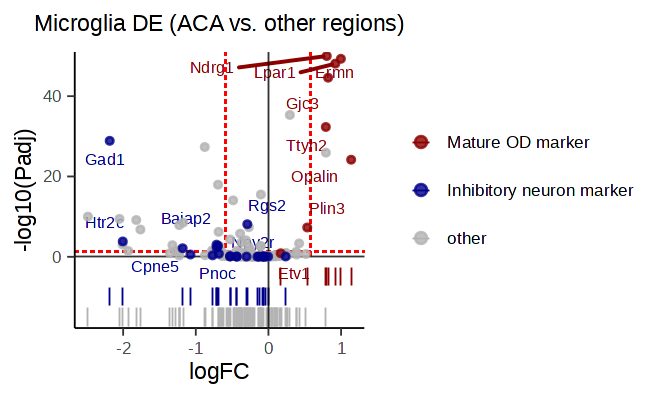

In [6]:
####### trying adding neuron markers to the plot

options(repr.plot.width = 3.25, repr.plot.height = 2, repr.plot.res = 200)

## making volcano plot for original DE
de_out_orig$padj <- 2*pnorm(abs(de_out_orig$Z), mean = 0, sd = 1, lower.tail = FALSE) # convert z back to padj
de_out_orig$mark_other <- sapply(de_out_orig$Gene,function(x){
  if (x %in% markers_use[["Mature oligodendrocyte"]]) {
    return('Mature OD marker')
  } else if (x %in% markers_use[["Inhibitory"]]) {
    return('Inhibitory neuron marker')
  } else {
    return('other')
  }
})
de_out_orig <- de_out_orig[order(de_out_orig$Z,decreasing=TRUE),]
de_out_orig$logpv <- -log10(de_out_orig$padj)
genes_to_label <- markers_use[["Mature oligodendrocyte"]][markers_use[["Mature oligodendrocyte"]] %in% de_out_orig[1:30,'Gene']]
de_out_orig_flip <- de_out_orig[rev(1:nrow(de_out_orig)),]
genes_to_label2 <- markers_use[["Inhibitory"]][markers_use[["Inhibitory"]] %in% de_out_orig_flip[1:30,'Gene']]
genes_to_label <- unique(c(genes_to_label,genes_to_label2))
ndx_lab <- which(de_out_orig$Gene %in% genes_to_label)
de_out_orig$top_mark_other <- NA
de_out_orig[ndx_lab,'top_mark_other'] <- de_out_orig$Gene[ndx_lab]
de_out_orig$logpv[de_out_orig$logpv>50] <- 50
ymax <- max(de_out_orig$logpv,na.rm=TRUE) + 1
myColors <- c('red4','blue4','grey70')

# Helper variables
limits <- range(de_out_orig$logpv,na.rm = TRUE,finite = TRUE)
step   <- diff(limits) * 0.1
size   <- 0.45 * step

de_out_orig$mark_other <- factor(de_out_orig$mark_other,levels=c('Mature OD marker','Inhibitory neuron marker','other'))
bottom_lim <- min(limits[1] - as.numeric(de_out_orig$mark_other) * step - size) - .5

p <- ggplot(de_out_orig,aes(x=M,y=logpv,color=mark_other,label=top_mark_other)) +
  geom_segment(aes(y=ymax,yend=0,x = log2(1.5)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_segment(aes(y=ymax,yend=0,x = -log2(1.5)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_hline(yintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_segment(aes(x=-Inf,xend=Inf,y = -log10(.05)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_segment(
    aes(
      color = mark_other,
      xend = M,
      y    = limits[1] - as.numeric(mark_other) * step + size,
      yend = limits[1] - as.numeric(mark_other) * step - size
    ),
      linewidth=gg_line_thickness
  ) +
  geom_text_repel(size=geom_text_size, family=font_choice, show.legend = FALSE) +
  geom_vline(xintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='other',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='Mature OD marker',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='Inhibitory neuron marker',],alpha=gg_point_alpha,size=gg_point_size) +
  scale_y_continuous(limits=c(bottom_lim,ymax),expand = c(0, 0)) +
  xlab('logFC') +
  ylab('-log10(Padj)') +
  ggtitle('Microglia DE (ACA vs. other regions)') +
  scale_colour_manual(breaks = c('Mature OD marker','Inhibitory neuron marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [7]:
pdf(OutputPath('brain_micro_de.pdf'), useDingbats=FALSE, width=3.45, height=2)
p
dev.off()

Warning message:
“Removed 120 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


png 
  2

In [27]:
## run fgsea
mystats <- de_out_orig$M
names(mystats) <- rownames(de_out_orig)
mystats <- mystats[!is.na(mystats)]
mystats <- mystats[is.finite(mystats)]
set_list <- list(markers_use[["Mature oligodendrocyte"]],markers_use[["Inhibitory"]])
names(set_list) <- c('mature_OD_markers','inhibitory_markers')
fgsea_res <- fgsea::fgseaSimple(
  pathways=set_list, stats = mystats, minSize=5, nperm=10000
)
print(head(fgsea_res))

[1] 135  13

[1] 102  13

              pathway         pval        padj         ES       NES
               <char>        <num>       <num>      <num>     <num>
1:  mature_OD_markers 0.0005184033 0.001036807  0.9648389  2.654725
2: inhibitory_markers 0.0387713457 0.038771346 -0.5845082 -1.451164
   nMoreExtreme  size  leadingEdge
          <num> <int>       <list>
1:            0     8 Opalin, ....
2:          360    23 Gad1, Ht....


In [28]:
## run de for cleaned data
dat_pgda_cln <- basicP2proc(dat_cln, n.cores=1, min.cells.per.gene=0,
                        n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_cln$regions_compare
names(regions_compare) <- rownames(meta_cln)
de_out_cln <- dat_pgda_cln$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                        upregulated.only=FALSE,append.auc = TRUE)
de_out_cln <- de_out_cln[['ACA']]

# order genes the same in both de results matrixes
de_out_orig <- de_out_orig[rownames(de_out_cln),]

506 cells, 135 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

3 overdispersed genes ... 3

persisting ... 

done.

running PCA using 135 OD genes .

.

Warning message in irlba(x, nv = nPcs, nu = 0, center = cm, right_only = FALSE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”
.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 1 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 120 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


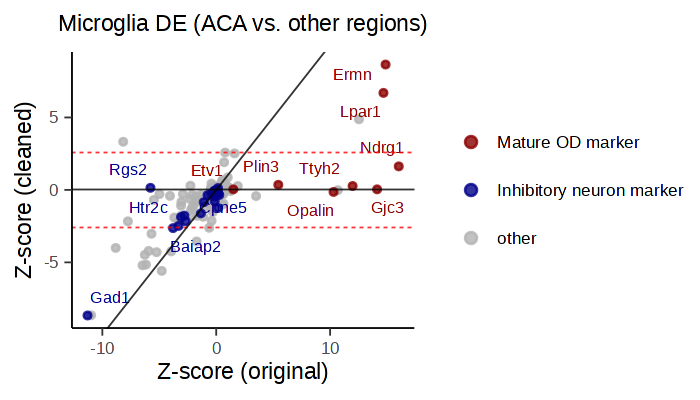

In [29]:
### also showing inhibitory neuron markers here

options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 200)

#### plot DE comparison
z_thresh <- qnorm(.01/2,lower.tail = FALSE)
tmp <- cbind.data.frame(de_out_orig[,'Z'],de_out_cln[,'Z'])
colnames(tmp) <- c('orig','clean')
rownames(tmp) <- rownames(de_out_orig)

## trying to color points by tumor marker set belonging
tmp$markers <- sapply(rownames(tmp),function(x){
  if (x %in% markers_use[["Mature oligodendrocyte"]]) {
    return('Mature OD marker')
  } else if (x %in% markers_use[["Inhibitory"]]) {
    return('Inhibitory neuron marker')
  } else {
    return('other')
  }
})
ndx_lab <- match(genes_to_label,rownames(tmp))
genes_to_label <- genes_to_label[!is.na(ndx_lab)]
ndx_lab <- ndx_lab[!is.na(ndx_lab)]
tmp$glab <- NA
tmp[ndx_lab,'glab'] <- genes_to_label
z_upper_thresh <- 20
tmp[which(tmp$orig>z_upper_thresh),'orig'] <- z_upper_thresh
tmp[which(tmp$orig<(-z_upper_thresh)),'orig'] <- -z_upper_thresh
tmp[which(tmp$clean>z_upper_thresh),'clean'] <- z_upper_thresh
tmp[which(tmp$clean<(-z_upper_thresh)),'clean'] <- -z_upper_thresh
tmp$markers <- factor(tmp$markers,levels=c('Mature OD marker','Inhibitory neuron marker','other'))
myColors <- c('red4','blue4','grey70')
p <- ggplot(tmp,aes(x=orig,y=clean,color=markers,label=glab)) +
  geom_point(data=tmp[tmp$markers=='other',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=tmp[tmp$markers=='Mature OD marker',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=tmp[tmp$markers=='Inhibitory neuron marker',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_text_repel(size=geom_text_size,show.legend = FALSE,family=font_choice) +
  ggtitle('Microglia DE (ACA vs. other regions)') +
  xlab('Z-score (original)') +
  ylab('Z-score (cleaned)') +
  geom_hline(linewidth=gg_line_thickness, yintercept = z_thresh,color='red',linetype='dashed',alpha=gg_line_alpha) +
  geom_hline(linewidth=gg_line_thickness, yintercept = -1*z_thresh,color='red',linetype='dashed',alpha=gg_line_alpha) +
  geom_hline(linewidth=gg_line_thickness, yintercept = 0,alpha=gg_line_alpha) +
  geom_abline(linewidth=gg_line_thickness, slope = 1,intercept=0,alpha=gg_line_alpha) +
  scale_colour_manual(breaks = c('Mature OD marker','Inhibitory neuron marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [16]:
pdf(OutputPath('brain_de_pre_post.pdf'), useDingbats=FALSE, width=3.75, height=2)
p
dev.off()

Warning message:
“Removed 120 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2